In [1]:
import pandas as pd
import json
import pyomo.environ as pyo
from pyomo.util.infeasible import *
import networkx as nx
import matplotlib.pyplot as plt

## Data 

In [2]:
with open("../data/mock.json") as f:
    d = json.load(f)
nodes, channels = pd.DataFrame(d["nodes"]), pd.DataFrame(d["edges"])

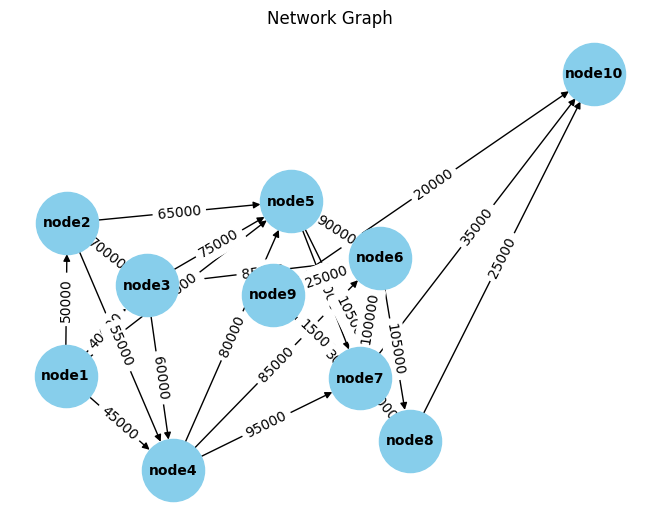

In [3]:
G = nx.DiGraph()

# Add nodes to the graph
for _, node in nodes.iterrows():
    G.add_node(node['pub_key'], alias=node['alias'])

# Add edges to the graph
for _, edge in channels.iterrows():
    G.add_edge(edge['node1_pub'], edge['node2_pub'], capacity=edge['capacity'], base_fee=edge['base_fee'], perc_fee=edge['perc_fee'])

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

# Add edge labels
edge_labels = {(u, v): f"{d['capacity']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Network Graph')
plt.show()

## Model

In [4]:
#channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.set_index("channel_id", inplace=True)
nodes.set_index("pub_key", inplace=True)

### Sets

In [5]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=channels.index)#, within=model.NODES*model.NODES)

In [ ]:
#model.add_component("addresses", pyo.Param(model.NODES, initialize=nodes["addresses"].to_dict(), within=pyo.Reals))
#model.add_component("capacity", pyo.Param(model.CHANNELS, initialize=channels["capacity"].to_dict(), within=pyo.Reals))
#model.add_component("base_fee", pyo.Param(model.CHANNELS, initialize=channels["base_fee"].to_dict(), within=pyo.Reals))
#model.add_component("perc_fee", pyo.Param(model.CHANNELS, initialize=channels["perc_fee"].to_dict(), within=pyo.Reals))

### Variables

In [6]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.Binary)

In [7]:
def find_a_bound():
    return max(nodes["demand"])

In [8]:
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0,find_a_bound()))

### Objective function

$$\min \sum _{(i,j) \in E} x_{i,j} \times (baseFee_{i,j} + rateFee_{i,j} \times amount_{i,j})$$

In [9]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(channels.loc[k]["base_fee"] * model.x[k] for k in model.CHANNELS) + sum(channels.loc[i]["perc_fee"] * model.a[i] for i in model.CHANNELS)

#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.x[i]*(channels.loc[i]["base_fee"] + channels.loc[i]["perc_fee"] * model.a[i]) for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.x[i] * channels.loc[i]["base_fee"] for i in model.CHANNELS)


In [10]:
model.totalCost = pyo.Objective(expr=objective_function(model), sense=pyo.minimize)

### Constraints

#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [11]:
# Capacity constrain
def capacity_constraint(model: pyo.ConcreteModel, a):
    return model.a[a] <= channels.loc[a]["capacity"] * model.x[a]
model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{si} - \sum_{(i,t) \in E} amount_{it} = b_i \text{ } \forall i \in V$$

In [12]:
def compute_outgoing(n: str) -> list:
    """
    Compute outgoing channels list for the node n
    :param n: node identifier
    :return: list of outgoing channels for node n
    """
    return [c for c in model.CHANNELS if channels.loc[c]["node1_pub"] == n]


def compute_incoming(n: str) -> list:
    """
    Compute incoming channels list for the node n
    :param n: node identifier
    :return: list of incoming channels for node n
    """
    return [c for c in model.CHANNELS if channels.loc[c]["node2_pub"] == n]


In [13]:
# Flow constrain
def flow_balance_constraint(model: pyo.ConcreteModel, n):
    return sum(model.a[a] for a in compute_outgoing(n)) - sum(model.a[a] for a in compute_incoming(n)) == nodes.loc[n]["demand"]
model.FlowBalanceConstrain = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

#### Single path constraint



## Solving the model

In [14]:
opt = pyo.SolverFactory("cbc")

In [15]:
from pyomo.opt import SolverStatus, TerminationCondition

results = opt.solve(model) # Solving a model instance  

try:
    model.load(results) # Loading solution into results object
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        print("Problem is feasible")# Do something when the solution in optimal and feasible
    elif results.solver.termination_condition == TerminationCondition.infeasible:
        print("Problem is infeasible")# Do something when model in infeasible
    else:
        print ("Solver Status: ",  results.solver.status())
except:
    print("Something else went wrong and the solver didn't actually run the model")



model.name="Min cost flow problem";
    - termination condition: infeasible
    - message from solver: <undefined>
Something else went wrong and the solver didn't actually run the model
